## MSDS458 Research Assignment 3 - Part 2 LSTM

### Import Packages

In [ ]:
from packaging import version
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import string

import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k

import nltk
from nltk.corpus import stopwords

### Verify TensorFlow version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.19.0


### Plotting Model Performance Metrics

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### Mount Google Drive to Colab environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep-learning/A3')

### Load Data

In [ ]:
dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:90%]','train[90%:]', 'test'],batch_size = 64
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset

### Preparing Integer Sequence Datasets

In [ ]:
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

In [ ]:
@tf.keras.utils.register_keras_serializable()
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [ ]:
#Load text vectorization layers
loaded_vectorize_layer_model = tf.keras.models.load_model('vectorize_layer_model_5000.keras')
vectorize_layer_5000 = loaded_vectorize_layer_model.layers[0]

In [ ]:
int_train_ds = train_ds.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (vectorize_layer_5000(x), y),
    num_parallel_calls=4)

In [ ]:
max_tokens=len(vectorize_layer_5000.get_vocabulary())

### Baseline model: fully-connected nerural network

In [ ]:
inputs = keras.Input(shape=(None, ), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.GlobalAveragePooling1D()(embedded)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, None, 256)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,298,660 (4.95 MB)

 Trainable params: 1,298,660 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("FCNN.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("FCNN.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.7727 - loss: 0.6016 - val_accuracy: 0.8905 - val_loss: 0.3154
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9017 - loss: 0.2785 - val_accuracy: 0.8919 - val_loss: 0.3101
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9130 - loss: 0.2504 - val_accuracy: 0.8906 - val_loss: 0.3136
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9190 - loss: 0.2298 - val_accuracy: 0.8839 - val_loss: 0.3272
Epoch 5/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9250 - loss: 0.2121 - val_accuracy: 0.8805 - val_loss: 0.3396
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8930 - loss: 0.3075
Test acc: 0.893
CPU times: user 3min 35s, sys: 16.3 s, total: 3min 52s
Wall time: 2min 40s


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
0,0.857,0.406,0.891,0.315
1,0.904,0.273,0.892,0.310
2,0.914,0.247,0.891,0.314
3,0.920,0.226,0.884,0.327
4,0.927,0.208,0.881,0.340


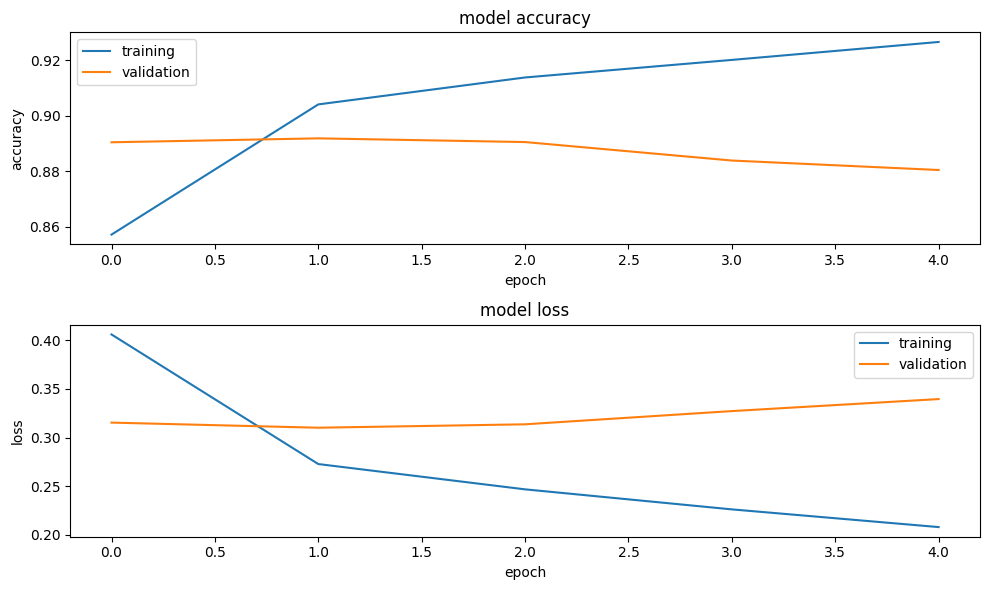

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.87      0.90      1900
           1       0.96      0.96      0.96      1900
           2       0.83      0.88      0.86      1900
           3       0.87      0.86      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy Score: 0.8931578947368422
Root Mean Square Error: 0.5617172916952742


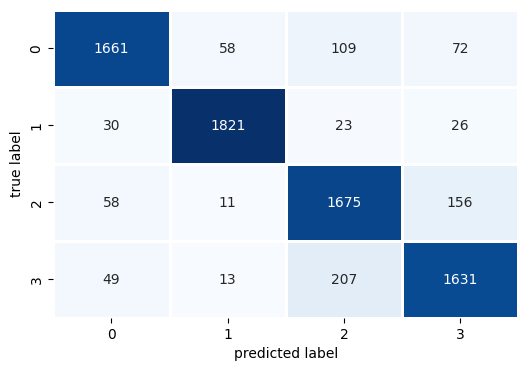

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 2: simple RNN with different units

In [ ]:
inputs = keras.Input(shape=(None, ), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256
                            ,mask_zero=True)(inputs)
x = layers.SimpleRNN(8)(embedded)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  1,280,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, None)      │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_1        │ (None, 8)         │      2,120 │ embedding_1[0][0… │
│ (SimpleRNN)         │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │         36 │ simple_rnn_1[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,282,156 (4.89 MB)

 Trainable params: 1,282,156 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("RNN_8u.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("RNN_8u.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 75s 43ms/step - accuracy: 0.6857 - loss: 0.7987 - val_accuracy: 0.8657 - val_loss: 0.4248
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 67s 40ms/step - accuracy: 0.8726 - loss: 0.4024 - val_accuracy: 0.8668 - val_loss: 0.4123
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 65s 38ms/step - accuracy: 0.9005 - loss: 0.3151 - val_accuracy: 0.8625 - val_loss: 0.4282
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 62s 37ms/step - accuracy: 0.9174 - loss: 0.2657 - val_accuracy: 0.8543 - val_loss: 0.4613
Epoch 5/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 63s 37ms/step - accuracy: 0.9261 - loss: 0.2387 - val_accuracy: 0.8528 - val_loss: 0.4896
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8742 - loss: 0.4105
Test acc: 0.871
CPU times: user 8min 2s, sys: 14.2 s, total: 8min 16s
Wall time: 5min 33s


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
0,0.795,0.588,0.866,0.425
1,0.881,0.375,0.867,0.412
2,0.905,0.303,0.863,0.428
3,0.920,0.260,0.854,0.461
4,0.927,0.235,0.853,0.490


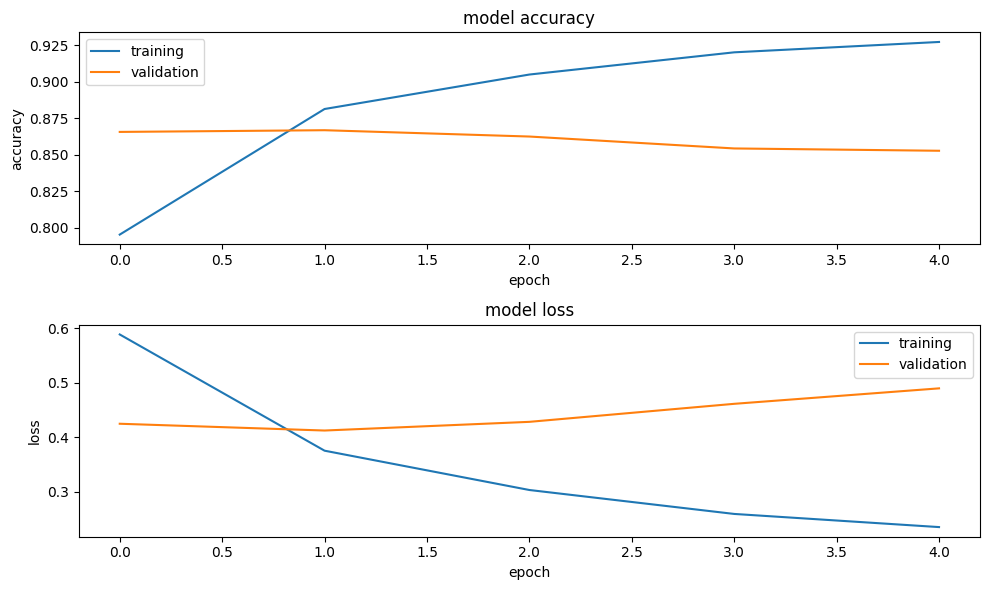

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1900
           1       0.93      0.95      0.94      1900
           2       0.81      0.86      0.83      1900
           3       0.84      0.82      0.83      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600

Accuracy Score: 0.8711842105263158
Root Mean Square Error: 0.5940494397288034


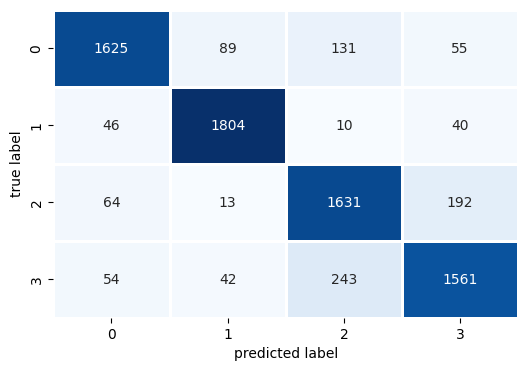

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
inputs = keras.Input(shape=(None, ), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256
                            ,mask_zero=True)(inputs)
x = layers.SimpleRNN(32)(embedded)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 256) │  1,280,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_2        │ (None, 32)        │      9,248 │ embedding_2[0][0… │
│ (SimpleRNN)         │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        132 │ simple_rnn_2[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,289,380 (4.92 MB)

 Trainable params: 1,289,380 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("RNN_32u.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("RNN_32u.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 73s 41ms/step - accuracy: 0.7865 - loss: 0.5622 - val_accuracy: 0.8820 - val_loss: 0.3480
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - accuracy: 0.9039 - loss: 0.2850 - val_accuracy: 0.8801 - val_loss: 0.3561
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 67s 40ms/step - accuracy: 0.9329 - loss: 0.2053 - val_accuracy: 0.8657 - val_loss: 0.4232
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 85s 42ms/step - accuracy: 0.9533 - loss: 0.1456 - val_accuracy: 0.8587 - val_loss: 0.5110
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8833 - loss: 0.3542
Test acc: 0.884
CPU times: user 6min 50s, sys: 9.39 s, total: 6min 59s
Wall time: 5min 19s


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
0,0.854,0.419,0.882,0.348
1,0.910,0.271,0.880,0.356
2,0.938,0.192,0.866,0.423
3,0.955,0.141,0.859,0.511


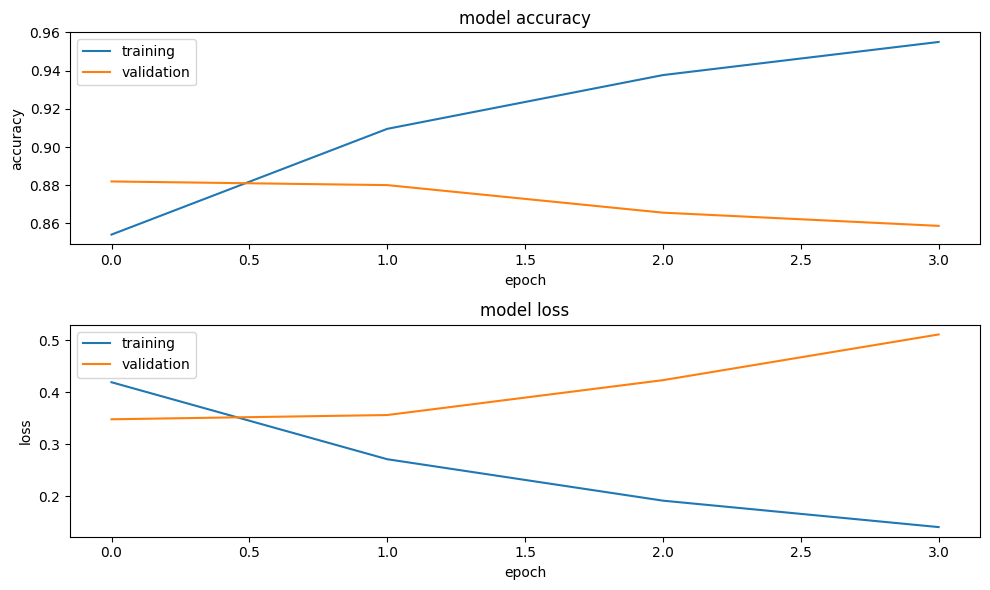

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1900
           1       0.95      0.96      0.95      1900
           2       0.82      0.88      0.85      1900
           3       0.87      0.82      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.89      0.88      0.88      7600
weighted avg       0.89      0.88      0.88      7600

Accuracy Score: 0.8843421052631579
Root Mean Square Error: 0.5897144714984844


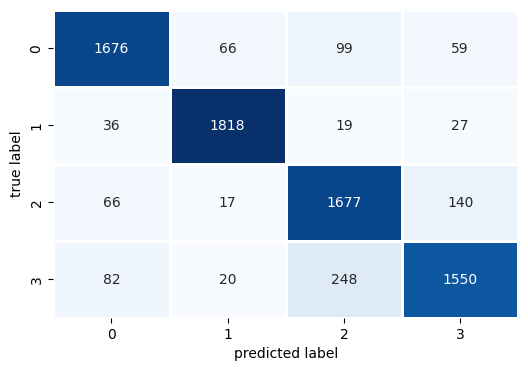

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 3: Bidirectional RNN

In [ ]:
inputs = keras.Input(shape=(None, ), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.SimpleRNN(32))(embedded)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, None, 256) │  1,280,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, None)      │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     18,496 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4)         │        260 │ bidirectional_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,298,756 (4.95 MB)

 Trainable params: 1,298,756 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("RNN_32u_bi.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("RNN_32u_bi.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 107s 61ms/step - accuracy: 0.8041 - loss: 0.5131 - val_accuracy: 0.8859 - val_loss: 0.3266
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 141s 60ms/step - accuracy: 0.9171 - loss: 0.2399 - val_accuracy: 0.8789 - val_loss: 0.3520
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 102s 61ms/step - accuracy: 0.9555 - loss: 0.1356 - val_accuracy: 0.8591 - val_loss: 0.4666
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 102s 61ms/step - accuracy: 0.9753 - loss: 0.0783 - val_accuracy: 0.8622 - val_loss: 0.5374
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8886 - loss: 0.3196
Test acc: 0.886
CPU times: user 10min 32s, sys: 11.1 s, total: 10min 43s
Wall time: 7min 35s


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
0,0.867,0.377,0.886,0.327
1,0.922,0.227,0.879,0.352
2,0.961,0.121,0.859,0.467
3,0.977,0.071,0.862,0.537


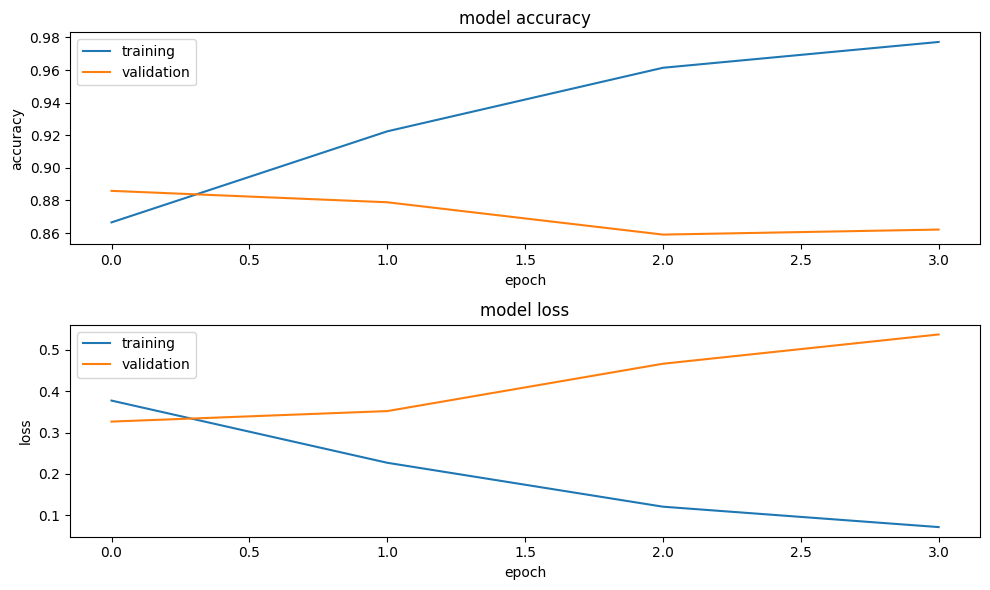

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1900
           1       0.95      0.96      0.95      1900
           2       0.82      0.88      0.85      1900
           3       0.86      0.82      0.84      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy Score: 0.8860526315789473
Root Mean Square Error: 0.5855721448652635


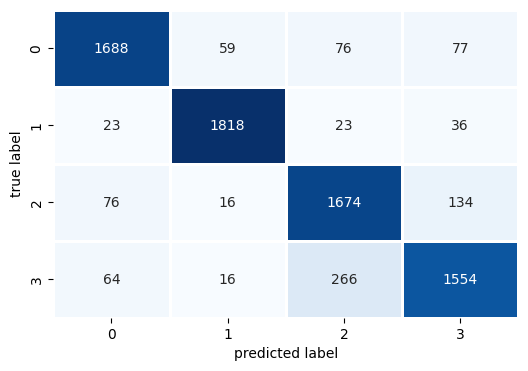

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 4: pretrained embeddings in simple bidirectional RNN

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-10-21 21:49:26--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-21 21:49:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.92MB/s    in 2m 41s  

2025-10-21 21:52:08 (5.11 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
embedding_dim = 100

vocabulary = vectorize_layer_5000.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

In [ ]:
inputs = keras.Input(shape=(None, ), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.SimpleRNN(32))(embedded)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, None, 100) │    500,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_8         │ (None, None)      │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │      8,512 │ embedding_5[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │        260 │ bidirectional_2[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 508,772 (1.94 MB)

 Trainable params: 8,772 (34.27 KB)

 Non-trainable params: 500,000 (1.91 MB)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("RNN_32u_bi_pretrain_embed.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("RNN_32u_bi_pretrain_embed.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.7788 - loss: 0.5714 - val_accuracy: 0.8693 - val_loss: 0.3808
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 84s 35ms/step - accuracy: 0.8700 - loss: 0.3709 - val_accuracy: 0.8739 - val_loss: 0.3651
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 57s 34ms/step - accuracy: 0.8764 - loss: 0.3501 - val_accuracy: 0.8784 - val_loss: 0.3540
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 61s 36ms/step - accuracy: 0.8805 - loss: 0.3388 - val_accuracy: 0.8783 - val_loss: 0.3486
Epoch 5/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 67s 39ms/step - accuracy: 0.8837 - loss: 0.3302 - val_accuracy: 0.8798 - val_loss: 0.3449
Epoch 6/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 62s 37ms/step - accuracy: 0.8859 - loss: 0.3241 - val_accuracy: 0.8783 - val_loss: 0.3457
Epoch 7/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 61s 36ms/step - accuracy: 0.8871 - loss: 0.3182 - val_accuracy: 0.8776 - val_loss: 0.3445
Epoch 8/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 85s 38ms/step - accuracy: 

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
3,0.881,0.339,0.878,0.349
4,0.884,0.331,0.880,0.345
5,0.885,0.326,0.878,0.346
6,0.887,0.319,0.878,0.344
7,0.889,0.313,0.878,0.345


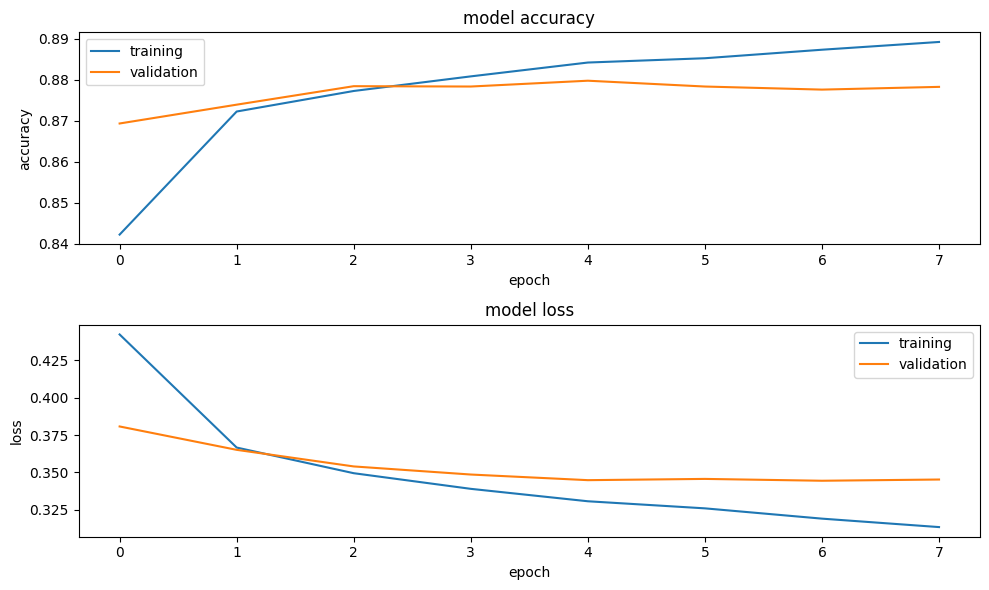

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1900
           1       0.94      0.95      0.95      1900
           2       0.84      0.83      0.83      1900
           3       0.81      0.85      0.83      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600

Accuracy Score: 0.8732894736842105
Root Mean Square Error: 0.631101793440813


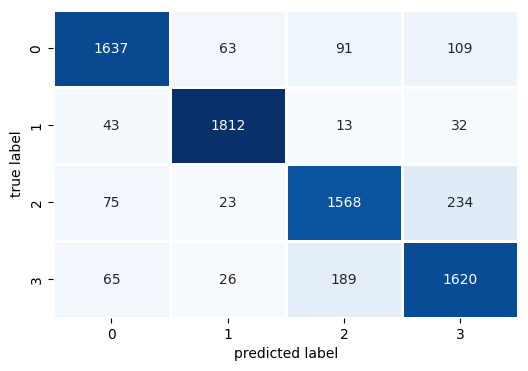

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 5: decrease embedding dimensions and add regularizers

In [ ]:
! pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    inputs = keras.Input(shape=(None, ), dtype="int64")
    embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=hp.Int('units', min_value=50, max_value=250, step=50)
                            ,mask_zero=True
                            ,embeddings_regularizer=tf.keras.regularizers.L2(hp.Float('l2_reg_1', min_value=1e-4, max_value=1e-2, sampling='LOG')))(inputs)
    x = layers.Bidirectional(layers.SimpleRNN(32,
                                              kernel_regularizer=tf.keras.regularizers.L2(hp.Float('l2_reg_2', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                                              recurrent_regularizer=tf.keras.regularizers.L2(hp.Float('l2_reg_3', min_value=1e-4, max_value=1e-1, sampling='LOG'))))(embedded)
    outputs = layers.Dense(4, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner',
    project_name='RNN_32_bi'
)

tuner.search(int_train_ds, epochs=50, validation_data=int_val_ds)

Trial 30 Complete [00h 19m 48s]
val_accuracy: 0.8744999766349792

Best val_accuracy So Far: 0.8924166560173035
Total elapsed time: 03h 29m 03s


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]

In [ ]:
best_hps.values

{'units': 50,
 'l2_reg_1': 0.000870589924664388,
 'l2_reg_2': 0.0005342767472521939,
 'l2_reg_3': 0.0004464716944325178,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0013'}

In [ ]:
inputs = keras.Input(shape=(None, ), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=50
                            ,mask_zero=True
                            ,embeddings_regularizer=tf.keras.regularizers.L2(0.00087))(inputs)
x = layers.Bidirectional(layers.SimpleRNN(32,
                                          kernel_regularizer=tf.keras.regularizers.L2(0.00053),
                                          recurrent_regularizer=tf.keras.regularizers.L2(0.00045)))(embedded)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 50)  │    250,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │      5,312 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        260 │ bidirectional[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 255,572 (998.33 KB)

 Trainable params: 255,572 (998.33 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("RNN_32u_bi_regularized.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("RNN_32u_bi_regularized.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 88s 49ms/step - accuracy: 0.7838 - loss: 0.7359 - val_accuracy: 0.8803 - val_loss: 0.4767
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 70s 42ms/step - accuracy: 0.8856 - loss: 0.4561 - val_accuracy: 0.8823 - val_loss: 0.4500
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 72s 43ms/step - accuracy: 0.8903 - loss: 0.4262 - val_accuracy: 0.8849 - val_loss: 0.4298
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 69s 41ms/step - accuracy: 0.8963 - loss: 0.3973 - val_accuracy: 0.8861 - val_loss: 0.4144
Epoch 5/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 72s 42ms/step - accuracy: 0.9011 - loss: 0.3749 - val_accuracy: 0.8848 - val_loss: 0.4101
Epoch 6/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.9041 - loss: 0.3609 - val_accuracy: 0.8874 - val_loss: 0.4039
Epoch 7/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - accuracy: 0.9067 - loss: 0.3526 - val_accuracy: 0.8863 - val_loss: 0.4018
Epoch 8/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 71s 42ms/step - accuracy: 

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
4,0.902,0.373,0.885,0.410
5,0.904,0.360,0.887,0.404
6,0.907,0.353,0.886,0.402
7,0.908,0.348,0.885,0.403
8,0.909,0.345,0.885,0.406


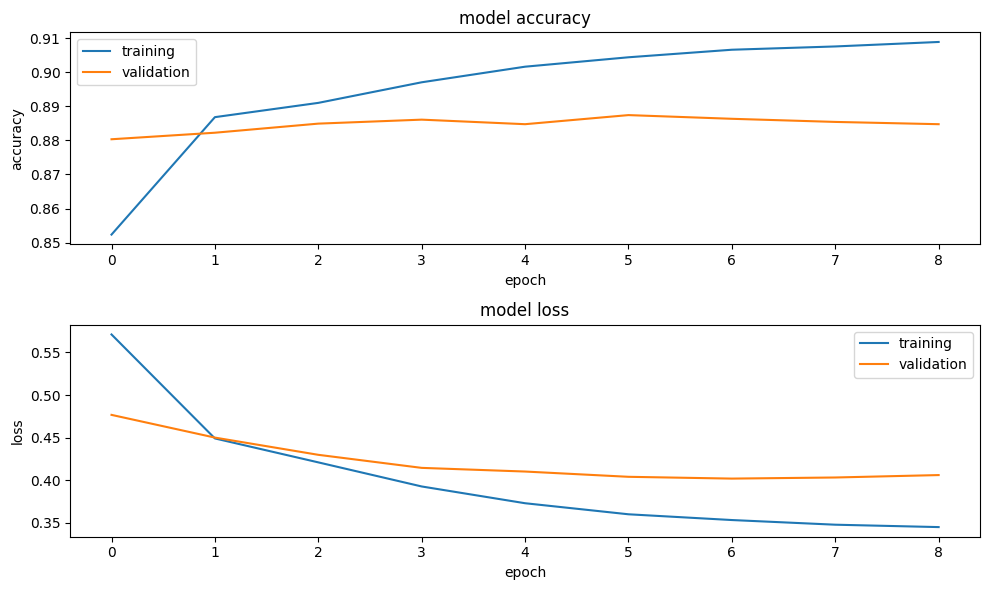

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1900
           1       0.95      0.95      0.95      1900
           2       0.82      0.88      0.85      1900
           3       0.87      0.82      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.89      0.88      0.88      7600
weighted avg       0.89      0.88      0.88      7600

Accuracy Score: 0.8847368421052632
Root Mean Square Error: 0.5689325184293088


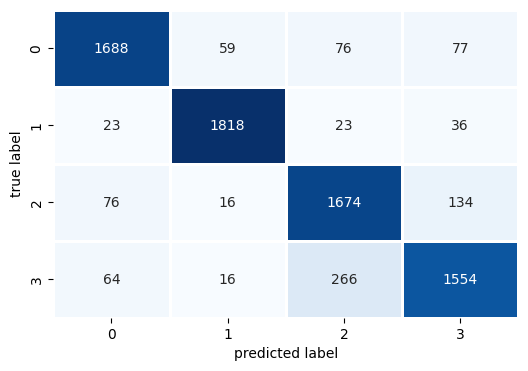

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 6: switch simple RNN to LSTM

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  1,280,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, None)      │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     73,984 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,354,244 (5.17 MB)

 Trainable params: 1,354,244 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_32u_bi.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("LSTM_32u_bi.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 140s 80ms/step - accuracy: 0.8230 - loss: 0.5119 - val_accuracy: 0.8952 - val_loss: 0.3073
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 129s 76ms/step - accuracy: 0.9041 - loss: 0.2790 - val_accuracy: 0.8957 - val_loss: 0.3026
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 133s 79ms/step - accuracy: 0.9192 - loss: 0.2351 - val_accuracy: 0.8942 - val_loss: 0.3130
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 124s 73ms/step - accuracy: 0.9309 - loss: 0.1943 - val_accuracy: 0.8863 - val_loss: 0.3463
Epoch 5/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 119s 71ms/step - accuracy: 0.9417 - loss: 0.1625 - val_accuracy: 0.8873 - val_loss: 0.3705
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8938 - loss: 0.3093
Test acc: 0.894
CPU times: user 16min 48s, sys: 47.3 s, total: 17min 35s
Wall time: 10min 48s


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
0,0.873,0.378,0.895,0.307
1,0.907,0.271,0.896,0.303
2,0.921,0.228,0.894,0.313
3,0.933,0.189,0.886,0.346
4,0.943,0.159,0.887,0.370


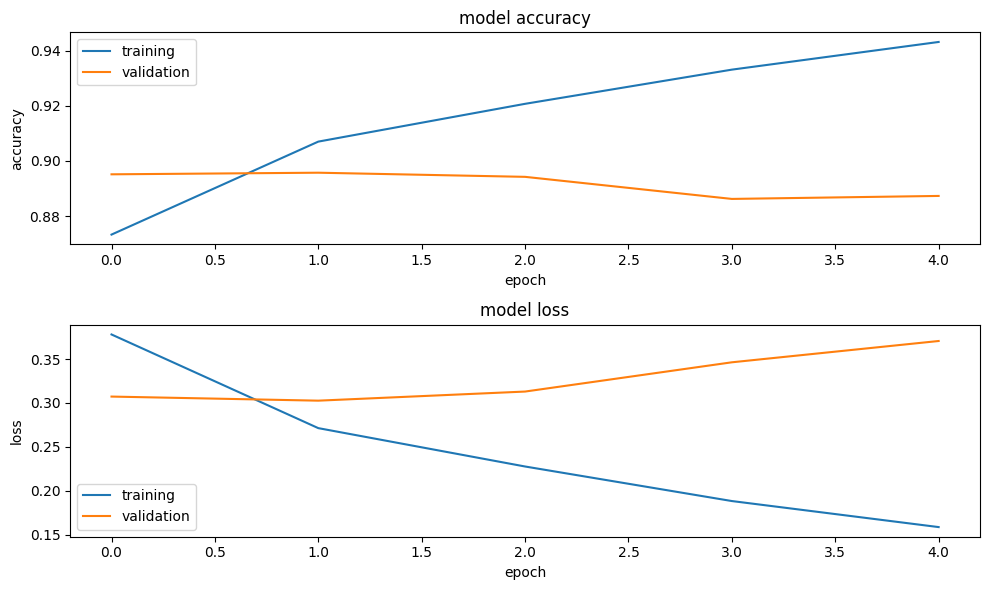

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1900
           1       0.94      0.97      0.95      1900
           2       0.84      0.88      0.86      1900
           3       0.87      0.85      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy Score: 0.8936842105263157
Root Mean Square Error: 0.55310130413115


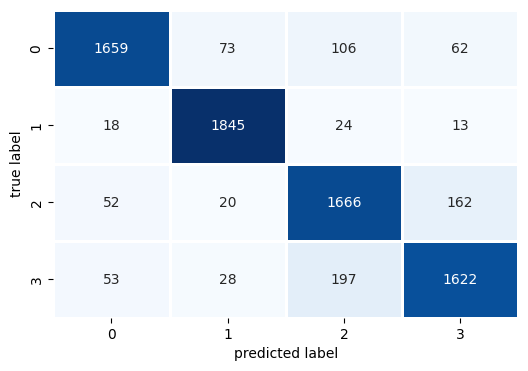

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 7: Switch to GRU

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.GRU(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 256) │  1,280,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     55,680 │ embedding_2[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        260 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,335,940 (5.10 MB)

 Trainable params: 1,335,940 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("GRU_32u_bi.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("GRU_32u_bi.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 118s 68ms/step - accuracy: 0.8106 - loss: 0.5295 - val_accuracy: 0.8957 - val_loss: 0.3029
Epoch 2/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 116s 69ms/step - accuracy: 0.9055 - loss: 0.2786 - val_accuracy: 0.8967 - val_loss: 0.3009
Epoch 3/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 151s 74ms/step - accuracy: 0.9190 - loss: 0.2351 - val_accuracy: 0.8913 - val_loss: 0.3261
Epoch 4/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 133s 79ms/step - accuracy: 0.9327 - loss: 0.1968 - val_accuracy: 0.8860 - val_loss: 0.3538
Epoch 5/200
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 131s 77ms/step - accuracy: 0.9435 - loss: 0.1650 - val_accuracy: 0.8837 - val_loss: 0.3807
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8956 - loss: 0.3081
Test acc: 0.895
CPU times: user 16min 12s, sys: 42 s, total: 16min 54s
Wall time: 10min 52s


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
0,0.870,0.383,0.896,0.303
1,0.908,0.273,0.897,0.301
2,0.921,0.228,0.891,0.326
3,0.934,0.193,0.886,0.354
4,0.944,0.162,0.884,0.381


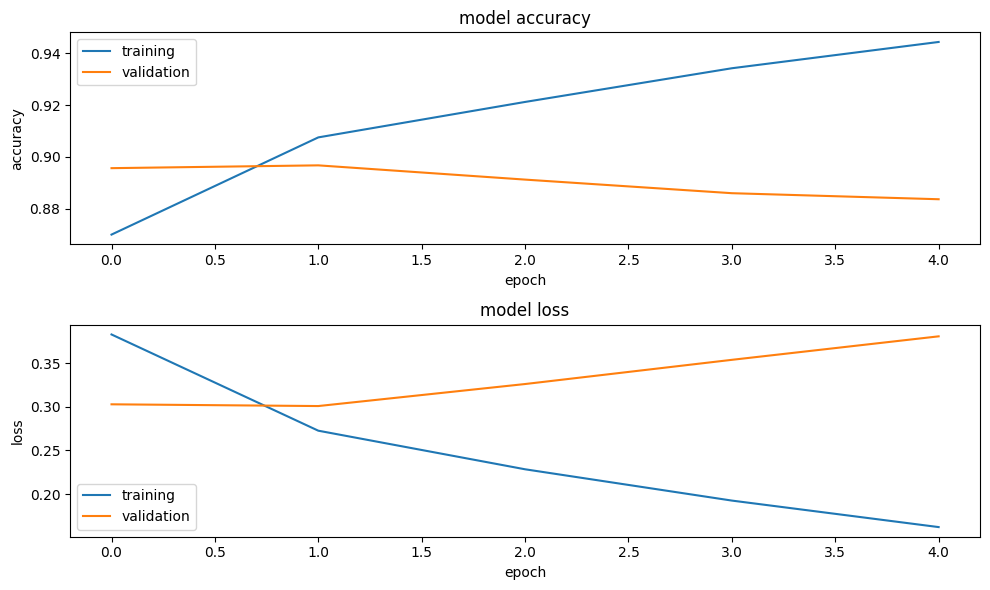

In [ ]:
plt.figure(figsize=(10, 6))
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)
plt.tight_layout()

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


In [ ]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1900
           1       0.94      0.96      0.95      1900
           2       0.86      0.86      0.86      1900
           3       0.86      0.86      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy Score: 0.8946052631578948
Root Mean Square Error: 0.5568945851302277


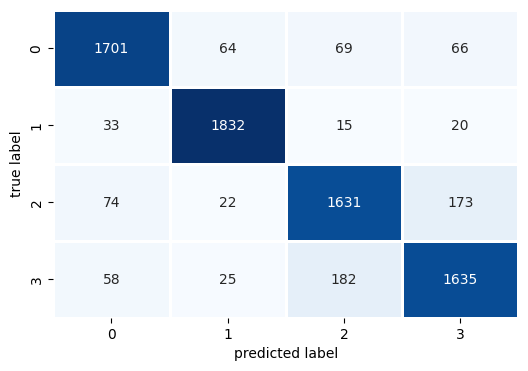

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
# Time Stamp
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the formatted time
print("Last Run:", formatted_time)